# XGBoost Benchmark for WHL Hockey

成功加载数据: 25827 条记录
Accuracy: 0.5779

Feature Importances:
home_team: 0.1674
away_team: 0.1670
game_num: 0.1964
home_penalty_minutes: 0.2165
away_penalty_minutes: 0.2527


d:\zhaor\PythonAndSuppliments\envs\warton_data_science\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:06:28] WARNING: C:\miniconda3\conda-bld\xgboost-split_1764761400759\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


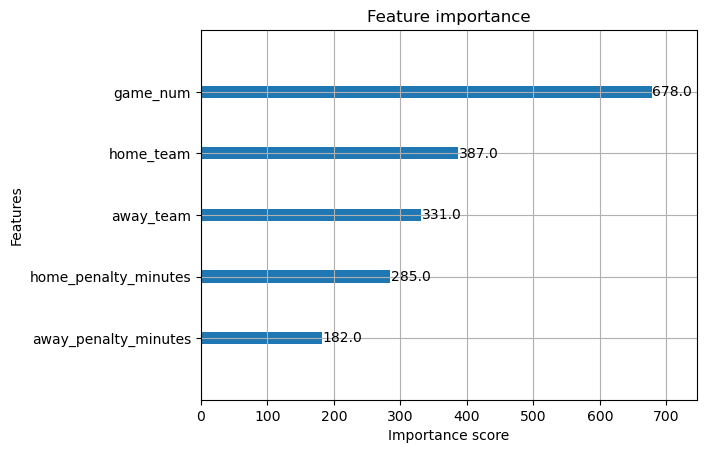

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# 1. 加载数据 (Load Data)
data_path = 'd:/A/Warton/Data/whl_2025.csv'
try:
    df_raw = pd.read_csv(data_path)
    print(f"成功加载数据: {len(df_raw)} 条记录")
except FileNotFoundError:
    print(f"未找到文件: {data_path}，请检查路径")
    # 如果找不到文件，这里不继续运行后续可能会报错，但在Notebook中用户可以修正路径

# 2. 数据预处理 (Preprocessing)
# 将 shift-level 数据聚合为 game-level
# 按照 Phase1a 的逻辑聚合关键字段
agg_rules = {
    'home_goals': 'sum', 
    'away_goals': 'sum',
    'home_team': 'first', 
    'away_team': 'first',
    'home_penalty_minutes': 'sum', 
    'away_penalty_minutes': 'sum'
}

# Group by game_id
if 'game_id' in df_raw.columns:
    df_games = df_raw.groupby('game_id').agg(agg_rules).reset_index()
    
    # 提取时间特征 (从 game_id，假设形如 game_1)
    df_games['game_num'] = df_games['game_id'].apply(lambda x: int(x.split('_')[1]) if isinstance(x, str) and '_' in x else 0)
else:
    # Fallback if game_id missing
    df_games = df_raw.copy()
    df_games['game_num'] = range(len(df_games))

# 3. 定义标签 y (Target)
# 胜负 (1 = 主队胜, 0 = 主队负)
df_games['target'] = np.where(df_games['home_goals'] > df_games['away_goals'], 1, 0)

# 4. 定义特征 X (Features)
# 根据您的要求：阵容ID(Team), 时间(game_num), 罚时(penalty_minutes)
features = ['home_team', 'away_team', 'game_num', 'home_penalty_minutes', 'away_penalty_minutes']
X = df_games[features].copy()
y = df_games['target']

# 5. 编码分类特征 (Encoding)
le = LabelEncoder()
all_teams = pd.concat([X['home_team'], X['away_team']]).unique()
le.fit(all_teams)

X['home_team'] = le.transform(X['home_team'])
X['away_team'] = le.transform(X['away_team'])

# 6. 划分数据集 (Train/Test Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. 定义模型 (Define Model)
model = xgb.XGBClassifier(
    n_estimators=100,     # 种 100 棵树
    learning_rate=0.1,    # 学习率
    max_depth=5,          # 树深
    reg_lambda=1,         # L2 正则
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 8. 训练 (Train)
model.fit(X_train, y_train)

# 9. 预测 (Predict)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
print(f"Accuracy: {acc:.4f}")

# 10. 查看特征重要性 (Feature Importance)
print("\nFeature Importances:")
importances = model.feature_importances_
for name, imp in zip(features, importances):
    print(f"{name}: {imp:.4f}")

xgb.plot_importance(model)
plt.show()